[github.com/jankoslavic/pypinm](http://github.com/jankoslavic/pypinm), mar 2016

<center>
<img width=300 src="./fig/ladisk.png">
<br>
[izr.prof. dr. Janko Slavič](http://www.ladisk.si/~slavic)
<br><br><br>

<font size="10" color="f00e0e" face="garamond"><b>Interpolacija</b></font>

</center>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn # ta paket lahko odstranite, namenjen je lepšemu izrisu
%matplotlib inline
import sympy as sym
sym.init_printing()

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 1. Uvod

V okviru tega poglavja želimo odgovoriti na vprašanje: kako na podlagi končnega nabora parov $x_i, y_i$ določiti vmesne vrednosti. 

Primer diskretnih točk:

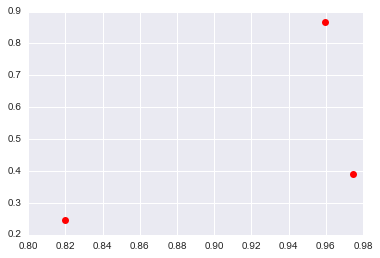

In [4]:
n = 3
x = np.random.rand(n)
x = np.sort(x)
y = np.random.rand(n)
plt.plot(x, y, 'ro');

V okviru interpolacije (ang. *interpolation*) točke povežemo tako, da predpostavimo neko funkcijo in dodamo pogoj, da funkcija *mora* potekati skozi podane točke. 

Pri aproksimaciji (ang. *approximation* ali tudi *curve fitting*) pa predpostavimo funkcijo, ki se čimbolje (glede na izbrani kriterij) prilega podatkom. 

# 2. Interpolacija s polinomom

V kolikor imamo podanih $n+1$ točk, lahko čez te točke interpoliramo polinom stopnje $n$. Zgornje točke tako lahko interpoliramo s funkcijo:
$$y_i = a_n\,x_i^n + a_{n-1}\,x_i^{n-1} +\cdots + a_{1}\,x_i + a_0.$$

Imamo $n+1$ neznank in vrednost funkcije poznamo pri $n+1$ vrednostih $x$ kar vodi v rešljiv sistem linearnih enačb. Linearne enačbe že vemo reševati in treba je definirati samo matriko koeficientov $\mathbf{A}$ in vektor konstant $\mathbf{b}$. 

To lahko naredimo relativno enostavno:

In [5]:
A = np.asarray([[_**p for p in reversed(range(len(x)))] for _ in x])
A

array([[ 0.67188458,  0.81968566,  1.        ],
       [ 0.92057822,  0.95946767,  1.        ],
       [ 0.94987038,  0.97461294,  1.        ]])

In [6]:
b = y

Koeficienti $a_{n}, a_{n-1},\dots$ torej so:

In [7]:
resitev = np.linalg.solve(A, b)
resitev

array([-231.99840012,  417.20704522, -185.85572034])

Pripravimo interpolacijsko funkcijo:

In [8]:
def y_function(x, resitev):
    A = np.asarray([[_**p for p in reversed(range(len(resitev)))] for _ in x])
    return A.dot(resitev)

In izris pri bolj gosti mreži točk:

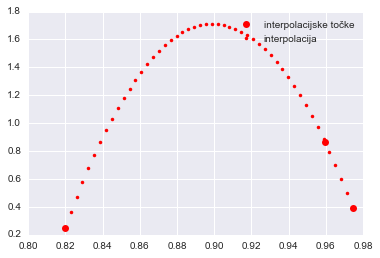

In [9]:
xint = np.linspace(np.min(x), np.max(x), 50)
yint = y_function(xint, resitev)
plt.plot(x, y, 'ro', label='interpolacijske točke')
plt.plot(xint, yint, 'r.',label='interpolacija');
plt.legend()
plt.show()

Slabosti zgornjega postopka so:
 * število numeričnih operacij raste sorazmerno z $n^3$,
 * nimamo ocene napake in 
 * problem je lahko slabo pogojen (z večanjem stopnje polinoma slaba pogojenost naglo narašča):

In [10]:
np.linalg.cond(A)

Iz tega stališča si bomo pogledali v nadaljevanju *Lagrangevo* metodo, ki ne zahteva reševanja sistema enačb.

# 3. Polinomska interpolacija - Lagrangeva metoda

Poglejmo si najprej Lagrangevo formulacijo polinomske interpolacije. Lagrangeva krivulja stopnje $n$ je definirana kot:
$$P_n(x)=\sum_{i=0}^{n}y_i\,l_i(x),$$
kjer $n$ definira stopnjo Lagrangevega polinoma:
$$l_i(x)=\prod_{j=0, j\ne i}^n \frac{x-x_j}{x_i-x_j}.$$

Opazimo torej, da je rezultat Lagrangeve polinomske interpolacije $n$ polinomov stopnje $n$ (polinome definiramo na podlagi $n+1$ točk). Poglejmo si za interpolacijo za zgoraj prikazane $x$ in $y$ podatke.

Definirajmo najprej Lagrangeve polinome $l_i(x)=\prod_{j=0, j\ne i}^n \frac{x-x_j}{x_i-x_j}$:

In [11]:
X = sym.symbols('X')
def Lagrange(X, x, i):
    """ Vrne Lagrangev polinom
    
    X: simbolna spremenljivka
    x: seznam podatkov
    i: indeks za katerega se računa polinom
    """
    li = 1
    n = len(x)
    for j in range(n):
        if j != i:
            li = li * ( (X-x[j]) / (x[i]-x[j]) )
    return li

Za podane točke $x$ je Lagrangev polinom v primeru $i=0$:

In [12]:
l0 = Lagrange(X, x, 0)
l0

Opazimo, da dobimo polinom stopnje:

In [13]:
stopnja = len(x)-1
stopnja

Pripravimo sliko

In [14]:
yint0 = sym.lambdify(X, l0, 'numpy')
def slika():
    xint = np.linspace(np.min(x), np.max(x), 30)
    plt.plot(x, y, 'ro', label='interpolacijske točke')
    plt.plot(xint, yint0(xint), 'r.',label='interpolacija');
    plt.axhline(0, color='k', linewidth=0.8);
    for _ in x[1:]:
        plt.axvline(_, color='k', linewidth=0.8);
    plt.legend()
    plt.show()

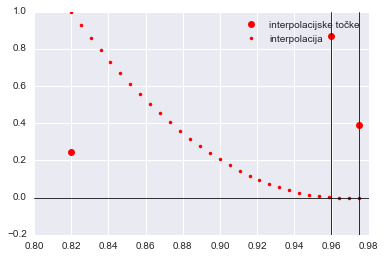

In [15]:
slika()

Opazimo, da ima polinom v prvi točki vrednost 1, v ostalih točkah pa nič:

In [16]:
[l0.subs(X, _) for _ in x] 

Če torej Lagrangev polinom za $i=0$ pomnožimo z $y_0$, bomo v prvi točki dobili pravo vrednost, v ostalih točkah pa nič:

In [17]:
def slika():
    plt.plot(x, y, 'ro', label='interpolacijske točke')
    plt.plot(xint, y[0]*yint0(xint), 'r.',label='interpolacija');
    plt.axhline(0, color='k', linewidth=0.8);
    for _ in x[1:]:    
        plt.axvline(_, color='k', linewidth=0.8);
    plt.legend()
    plt.show()

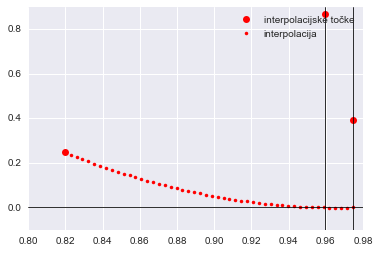

In [18]:
slika()

Če bi podobno analizo naradili še za ostale Lagrangeve polinome, bi ugotovili, da vsaka popiše točno vrednost samo v eni znani točki, v ostalih znanih točkah pa je nič. Izkaže se, da z vsoto takih krivulj ustrezno interpoliramo podatke. Poglejmo si torej celoto:

In [19]:
def interpolation_Lagrange(x, y):
    """ Izvede interpolacijo po Lagrangevi metodi.
    """
    X = sym.symbols('X')
    l = []
    interpolacijski_polinom = 0.
    for i in range(len(x)):
        li = Lagrange(X, x, i)
        interpolacijski_polinom += y[i]*li
        l.append(li)
    return interpolacijski_polinom, l    

In [20]:
interpolacijski_polinom, lagrangevi_polinomi = interpolation_Lagrange(x, y)
interpolacijski_polinom

Pripravimo funkcijo za numerične vrednosti:

In [21]:
yint = sym.lambdify(X, interpolacijski_polinom, 'numpy')

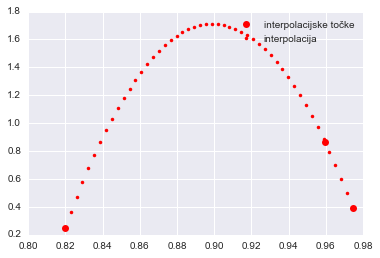

In [22]:
plt.plot(x, y, 'ro', label='interpolacijske točke')
plt.plot(xint, yint(xint), 'r.',label='interpolacija');
plt.legend()
plt.show()

Dodajmo še posamezne Lagrangeve krivulje:

In [23]:
yint_polinomi = []
for lp, y_ in zip(lagrangevi_polinomi, y):
    yint_polinomi.append(sym.lambdify(X, y_*lp, 'numpy')) # vsako posebej lambdificiramo

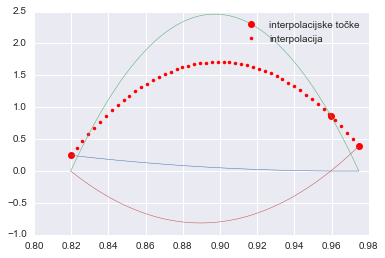

In [24]:
plt.plot(x, y, 'ro', label='interpolacijske točke')
plt.plot(xint, yint(xint), 'r.',label='interpolacija');
for yint_po in yint_polinomi:
    plt.plot(xint, yint_po(xint), linewidth=0.5)
plt.legend()
plt.show()

Poskusimo sedaj izvesti interpolacijo čez več točk:

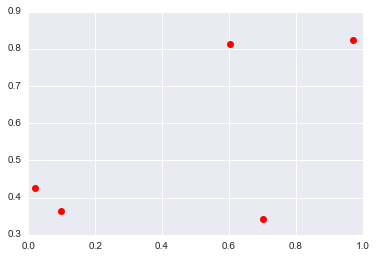

In [25]:
n = 5
x = np.random.rand(n)
x = np.sort(x)
y = np.random.rand(n)
plt.plot(x, y, 'ro');

In [26]:
interpolacijski_polinom, lagrangevi_polinomi = interpolation_Lagrange(x, y)
xint = np.linspace(np.min(x), np.max(x), 100)
yint = sym.lambdify(X, interpolacijski_polinom, 'numpy')
yint_polinomi = []
for lp, y_ in zip(lagrangevi_polinomi, y):
    yint_polinomi.append(sym.lambdify(X, y_*lp, 'numpy')) 

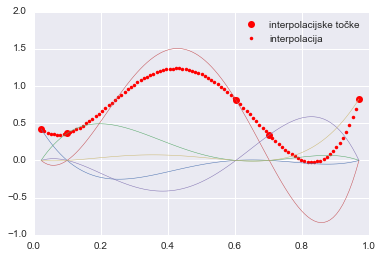

In [27]:
plt.plot(x, y, 'ro', label='interpolacijske točke')
plt.plot(xint, yint(xint), 'r.',label='interpolacija');
for yint_po in yint_polinomi:
    plt.plot(xint, yint_po(xint), linewidth=0.5)
plt.legend()
plt.show()

Ugotovimo, da interpolacija pri večjem številu točk (npr. 5) daje zelo napačne rezultate; predvsem na robovih. Posledično se interpolacija za več kot približno 5 točk redko uporablja (še posebej, če $\Delta x$ ni konstanta). 

Število matematičnih operacij sicer narašča sorazmerno z $n^2$ ([vir](http://www.ams.org/journals/mcom/1970-24-109/S0025-5718-1970-0258240-X/S0025-5718-1970-0258240-X.pdf)).

Lahko se pokaže (glejte npr.: Burden, Faires, Burden: Numerical Analysis), da je napaka Lagrangeve interpolacije:
$$e=\frac{f^{(n+1)}(\xi)}{(n+1)!}\,(x-x_0)\,(x-x_1)\,\cdots\,(x-x_n),$$
kjer je $f$ interpolirana funkcija, $n$ stopnja interpolacijskega polinoma in $\xi$ neznana vrednost na interpoliranem področju.

## Primer interpolacije

In [28]:
x = np.linspace(0, np.pi/2, 4)
y = np.sin(x)

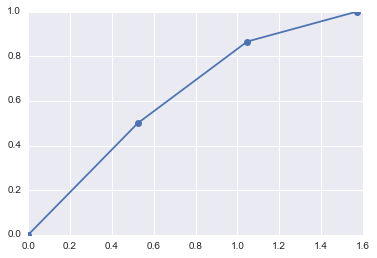

In [29]:
plt.plot(x, y, 'o-');

Linearna interpolacija (iščemo vrednosti pri $\sin(\pi/4)$)!

In [30]:
interpolacijski_polinom, lagrangevi_polinomi = interpolation_Lagrange(x[1:3], y[1:3])
y_linearna = interpolacijski_polinom.subs(X, x[-1]/2)
y_linearna

Kvadratna

In [31]:
interpolacijski_polinom, lagrangevi_polinomi = interpolation_Lagrange(x[0:3], y[0:3])
y_kvadratna = interpolacijski_polinom.subs(X, x[-1]/2)
y_kvadratna

Kubična

In [32]:
interpolacijski_polinom, lagrangevi_polinomi = interpolation_Lagrange(x, y)
y_kubična = interpolacijski_polinom.subs(X, x[-1]/2)
y_kubična

## Primer ocene napaka polinomske interpolacije

In [33]:
print('Linearna: ', np.sin(x[-1]/2)-y_linearna)
print('Kvadratna:', np.sin(x[-1]/2)-y_kvadratna)
print('Kubična:  ', np.sin(x[-1]/2)-y_kubična)

Linearna:  0.0240940792943283
Kvadratna: 0.00734725476738307
Kubična:   0.00121749155780082


*Napako ocenimo s pomočjo*
$$e=\frac{f^{(n+1)}(\xi)}{(n+1)!}\,(x-x_0)\,(x-x_1)\,\cdots\,(x-x_n)$$
kjer je v primeru linearne aproksimacije ($n=1$) drugi odvod sinusne funkcije ($f^{(n+1)}$) omejen z 1, velja:
$$e=\frac{1}{(2)!}\,(\pi/4-\pi/6)\,(\pi/4-\pi/3)=-\frac{1}{2}\,\frac{\pi}{12}\,\frac{\pi}{12}=-\frac{\pi^2}{288}=-0.033$$

Poleg **Lagrangeve metode** bi si tukaj lahko pogledali še **Newtonovo metodo** interpolacije, ki je numerično učinkovitejša. Kakor pa smo pokazali zgoraj, čez večje število točk taka interpolacija nima smisla in zato bomo tukaj nadaljevali z t.i. **kubičnimi zlepki** (ang. *cubic spline*).

### Interpolacija z uporabo `scipy`

In [34]:
x

array([ 0.        ,  0.52359878,  1.04719755,  1.57079633])

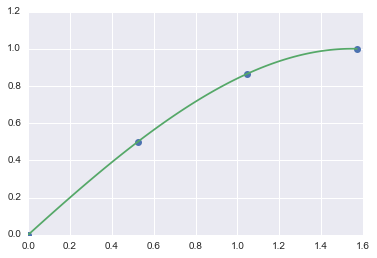

In [44]:
from scipy.interpolate import interp1d
f = interp1d(x, y, kind='cubic')
xnew = np.linspace(x[0], x[-1], 100)
ynew = f(xnew)   # uporabimo interpolacijsko funkcijo dobljeno z `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

# 4. Kubični zlepki

Poglejmo si najprej en preprost primer:

In [32]:
from scipy.interpolate import InterpolatedUnivariateSpline

n = 10
x = np.linspace(0, 10, n)
y = np.sin(x)+ 0.5*np.random.rand(n)
spl = InterpolatedUnivariateSpline(x, y)

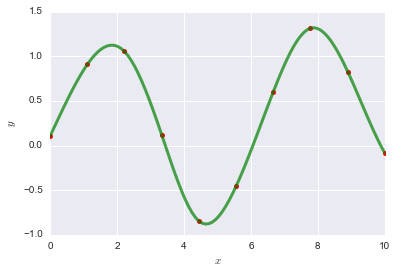

In [33]:
xint = np.linspace(0, 10, 10*n)
plt.plot(x, y, 'ro', ms=5)
plt.plot(xint, spl(xint), 'g', lw=3, alpha=0.7)
plt.xlabel('$x$')
plt.ylabel('$y$');

Kubični zlepki so zelo pogosti način interpolacije. Ob predpostavki $x_0<x_1< \cdots <x_n$ gre preprosto odsekovno interpolacijo s polinomom tretjega reda. 

Od točke $x_i$ do $x_{i+1}$ iščemo polinom:
$$f_{i,i+1}(x)= a_{i,0}\,x^3+a_{i,1}\,x^2+a_{i,2}\,x+a_{i,3},$$
pri čemer so neznane vrednosti konstant $a_{i,j}$. Če imamo na primer $n+1$ točk, potem je treba določiti $n$ polinomskih funkcij (za primer treh točk: $f_{0,1}(x), f_{1,2}(x)$). Posledično to pomeni $4n$ konstant $a_{i,j}$. 

Celotni zlepek je definiran kot:
$$f(x) = \left\{
\begin{array}[rcl]%
f_{0,1}(x); && x\in[x_0, x_1]\\
f_{1,2}(x); && x\in[x_1, x_2]\\
&\vdots&\\
f_{n-1,n}(x); && x\in[x_{n-1}, x_n]
\end{array}
\right.
$$


**Kako določimo konstante $a_{i,j}$?**

Za določitev $4n$ neznak, potrebujemo tudi $4n$ enačb. Poglejmo si katere so že znane:
* $n+1$ enačbo dobimo iz interpolacijskega pogoja: $$y_i=f_{i,i+1}(x_i)$$
in za zadnjo točko $$y_n=f_{n-1,n}(x_n)$$
* $2(n-1)$ enačb dobimo iz pogoja $C^1$zveznosti: 
$$\lim_{x\rightarrow x_i^-}f(x)=\lim_{x\rightarrow x_i^+}f(x)$$
in
$$\lim_{x\rightarrow x_i^-}f'(x)=\lim_{x\rightarrow x_i^+}f'(x)$$

Preostane še $n+1$ neznank. 

Različni tipi zlepkov (npr.: *Hermitovi*, *naravni*, *periodični*) se ločijo po tem kako te neznanke določimo. V nadaljevanju si bomo pogledali *naravne kubične zlepke*.

### Naravni kubični zlepki

*Naravni kubični zlepki* temeljijo na ideji Eulerjevega nosilca:
$$E\,I\,\frac{\textrm{d}^4y}{\textrm{d}x^4}=q(x),$$
kjer je $E$ elastični modul, $I$ pa drugi moment preseka in $q(x)$ zunanja porazdeljena sila. Ker zunanje porazdeljene sile ni ($q(x)=0$), velja:
$$E\,I\,\frac{\textrm{d}^4y}{\textrm{d}x^4}=0.$$
Sledi, da lahko v vsaki točki tanek nosilec popišemo s polinomom tretje stopnje. 

Sedaj $n-1$ neznank določimo iz predpostavke, da je nosilec v znanih točkah členkasto vpet in se torej moment v členkih ne spremeni; to pomeni, da je drugi odvod v členkih zvezen (to imenujemo $C^2$ zveznost):
$$\lim_{x\rightarrow x_i^-}f''(x)=\lim_{x\rightarrow x_i^+}f''(x)$$

Preostali 2 neznanki pri naravnih kubičnih zlepkih določimo iz pogoja, da je moment na koncih enak nič (členkasto vpetje):
$$f''(x_{0})=0\qquad\textrm{in}\qquad f''(x_{n})=0$$

Več podrobnosti izpeljave je prikazano v knjigi Kiusalaas J: Numerical Methods in Engineering with Python 3, 2013, stran 120; podrobna izpeljava presega obseg predavanj. Tukaj si bomo pogledali samo končni rezultat, ki ga lahko izpeljemo ob zgornjih pogojih v primeru ekvidistantne delitve $h=x_{i+1}-x_i$ (takim zlepkom rečemo, da so *uniformni*). 

Če uporabimo zapis  $k_i = f''_{i,i+1}$, potem za $0<i<n$ lahko izpeljemo:
$$\begin{align}
f_{i,i+1}(x)=&\frac{k_i}{6}\left(\frac{(x-x_{i+1})^3}{h}-(x-x_{i+1})\,h\right)\\
&-\frac{k_{i+1}}{6}\left(\frac{(x-x_{i})^3}{h}-(x-x_{i})\,h\right)\\
&+\frac{y_i\,(x-x_{i+1})-y_{i+1}\,(x-x_{i})}{h}\\
\end{align}$$

kjer $k_i$ določimo glede na linearni problem:
$$k_{{i-1}} + 4 k_{i} + k_{{i+1}}  =  \frac{6}{h^2} \left(y_{i-1} -2 y_{i} +y_{i+1} \right).$$
Naprej še velja:
$$k_0=k_n=0.$$

### Numerična implementacija

Najprej definirajmo funkcijo za izračun koeficientov $k_i$:

In [34]:
def kubicni_zlepki_koeficient(x, y):
    """ Vrne koeficiente kubičnih zlepkov `k`, matriko koeficientov `A`in konstant
    
    x in y predstavljata seznam znanih vrednosti.
    x mora biti ekvidistanten
    """
    n = len(x)
    A = np.zeros((n, n))
    _ = np.asarray([1, 4, 1])
    h = x[1]-x[0]
    for i in range(n-2):
        A[i, i:i+3] = _
    A = A[:-2, 1:-1] # k_0 in k_n sta nič zato odstranimo te člene
    b = (6/h**2)*(y[:-2] + y[2:] - 2*y[1:-1])
    k = np.linalg.solve(A,b)
    return k, A, b

Nato potrebujemo še funkcijo zlepka v določenem intervalu:

In [35]:
def kubicni_zlepki(k, x, y, x_najdi):
    """ Vrne kubicni zlepek pri delitvi `xint`
    
    k: koeficienti kubičnih zlepkov
    x in y: znane vrednosti, x mora biti ekvidistanten
    x_najdi: vrednosti kjer želimo izračunati kubični zlepek
    """
    # dodaj nič na začetku in koncu
    _ = k.copy()
    k = np.zeros(len(k)+2)
    k[1:-1] = _
    
    h = - x[1] + x[0]
    i = (x_najdi-x[0])//(-h)
    if i >= len(k)-1:
        i = len(k)-2
    out = ((x_najdi - x[i+1])**3/h - (x_najdi - x[i+1])*h)*k[i]/6.0 \
        - ((x_najdi - x[i])**3/h - (x_najdi - x[i])*h)*k[i+1]/6.0 \
        + (y[i]*(x_najdi - x[i+1]) \
        - y[i+1]*(x_najdi - x[i]))/h
    return out

In [36]:
x = np.asarray([1, 2, 3, 4, 5])
y = np.asarray([0, 1, 0, 1, 0])

k, A, b = kubicni_zlepki_koeficient(x, y)
print(A)
print(b)
k

[[ 4.  1.  0.]
 [ 1.  4.  1.]
 [ 0.  1.  4.]]
[-12.  12. -12.]


array([-4.28571429,  5.14285714, -4.28571429])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


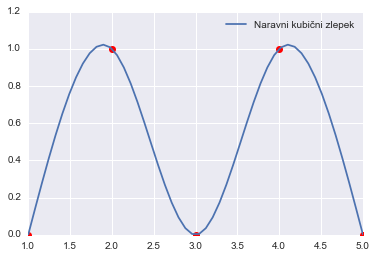

In [37]:
xint = np.linspace(np.min(x), np.max(x), 50)
yint = np.asarray([kubicni_zlepki(k, x, y, _) for _ in xint])
plt.plot(x, y, 'ro')
plt.plot(xint, yint, label='Naravni kubični zlepek')
plt.legend();

### Zlepki z eno spremenljivko in modul ``scipy.interpolate``

SciPy ima vgrajene naprednjejše metode za zlepke (B zlepke, ang *B spline*), ki so zelo primerni za numerično implementacijo, podrobneje pa se jih tukaj ne bomo dotaknili. Si bomo pa v nadaljevanju pogledali njihovo objektno implementacijo ``InterpolatedUnivariateSpline`` (starejši pristop temelji na funkcijskem programiranju, glejte: ``scipy.interpolate.splrep``):

In [38]:
from scipy.interpolate import InterpolatedUnivariateSpline

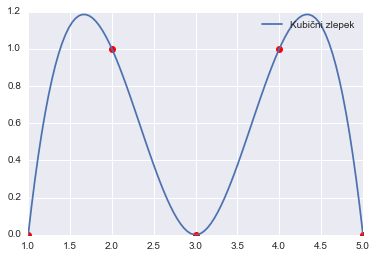

In [39]:
xint = np.linspace(np.min(x), np.max(x), 100)
spl = InterpolatedUnivariateSpline(x, y, k=3) # poglejte opcije!
plt.plot(x, y, 'ro')
plt.plot(xint, spl(xint), label='Kubični zlepek');
plt.legend();

Ker gre za drugačen tip zlepkov kakor smo ga izpeljali zgoraj, je rezultat malenkost drugačen. Napredna implementacija v okviru ``SciPy`` avtomatično prilagodi *vozle* zlepkov (ang. *knots*), to so točke kjer se zlepki lepijo. Pri interpolaciji z ``naravnimi kubičnimi zlepki`` so vozli v točkah kjer imamo podatke:

In [40]:
x

array([1, 2, 3, 4, 5])

Pri ``InterpolatedUnivariateSpline`` pa so v točkah (in zato je rezultat drugačen):

In [41]:
spl.get_knots()

array([ 1.,  3.,  5.])

Tipično zlepkov ne bomo iskali na tako majhnem številu točk in takrat se zgoraj prikazani pristop izkaže kot bolj primeren (tako numerično kakor glede natančnosti).

Opomba: kakor je navedeno v pomoči, lahko vozle prilagodimo (v tem primeru uporabimo ``LSQUnivariateSpline``).

## Odvajanje, integriranje,... zlepkov

Ko imamo enkrat zlepke definirane z objektom ``InterpolatedUnivariateSpline``, potem lahko dostopamo preko metod do odvodov, integralov, ničel, vozlov,... (glejte help).

Za prvi odvod na primer uporabimo metodo ``.derivative(1)``, ki vrne novi objekt spline krivulje (red je za 1 nižji):

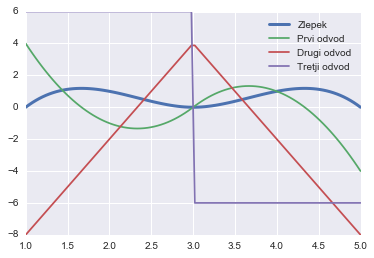

In [42]:
spl1 = spl.derivative(1)
spl2 = spl.derivative(2)
spl3 = spl.derivative(3)
plt.plot(xint, spl(xint), lw=3, label='Zlepek')
plt.plot(xint, spl1(xint), label='Prvi odvod')
plt.plot(xint, spl2(xint), label='Drugi odvod')
plt.plot(xint, spl3(xint), label='Tretji odvod')
plt.legend();

# Do naslednjih vaj preštudirajte sledeče:

1. Preštudirajte Lagrangevo polinomsko interpolacijo in pripravite funkcijo za Lagrangeve polinome. Pojasnite (z grafičnim prikazom) Lagrangeve polinome.
* Definirajte funkcijo za Lagrangevo polinomsko interpolacijo. Na primeru pojasnite kako deluje.
* Pojasnite teoretično ozadje naravnih kubičnih zlepkov.
* Naravne kubične zlepke smo izpeljali pod pogojem, da momenta na koncu ni; včasih želim drugačne pogoje na koncih (npr. znani naklon ali znani moment). Modificirajte na predavanjih predstavljeno kodo za primer, da je na koncih moment $\ne 0$ (predpostavite neko numerično vrednost).
* Podatke:
    ```python
    x = np.linspace(0, 10, 10)
    y = np.random.rand(10)-0.5
    ```
  interpolirajte z uporabo ``scipy.InterpolatedUnivariateSpline``. Podatke prikažite.
* Za zgoraj definirane podatke preučite pomoč in najdite vse ničle. Prikažite jih na predhodni sliki.
* Za zgoraj definirani zlepek izračunajte prvi odvod in ga prikažite.
* Za zgoraj definirani zlepek izračunajte integral od začetka do konca.
* Za zgoraj definirane podatke prikažite izračun linearnega in kvadratnega zlepka. Prikažite na sliki
* Preučite pomoč za funkcijo ``scipy.interpolate.lagrange`` in k predhodni sliki dodajte Lagrangev interpolacijski polinom. Komentirajte rezultate.
* Preučite pomoč za funkcijo ``scipy.interpolate.interp1d`` in k predhodni sliki dodajte kvadratni zlepek.
* Preučite pomoč za funkcijo ``scipy.interpolate.BarycentricInterpolator`` in pojasnite ter prikažite njeno prednost.
* Preučite pomoč za funkcijo ``scipy.interpolate.KroghInterpolator`` in pojasnite njeno prednost.

Delno rešene vaje se nahajajo [tukaj](./vaje/Vaja 7 - polovica.ipynb).

## Ekstra

* 2D interpolacja: https://www.youtube.com/watch?v=_cJLVhdj0j4
* Strojno prevajanje: https://pypi.python.org/pypi/goslate)